<a href="https://colab.research.google.com/github/brian8128/SchemaFuse/blob/main/examples/multiple_versions_of_schema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# import some dependencies
!pip install git+https://github.com/brian8128/SchemaFuse.git
from schemafuse import multiple_choice_cross_entropy

import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import time
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

import random
from sklearn.metrics import confusion_matrix


  Cloning https://github.com/brian8128/SchemaFuse.git to /tmp/pip-req-build-3ep7s297
  Running command git clone --filter=blob:none --quiet https://github.com/brian8128/SchemaFuse.git /tmp/pip-req-build-3ep7s297
  Resolved https://github.com/brian8128/SchemaFuse.git to commit 39909eebdf15ef7f2cbdbbb04fddfb6fe03f3c61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Training with Multiple Versions of the Schema

A common problem in applied machine learning in industry is how to train a model when you have data labeled with multiple versions of the schema. For our example we'll create multiple schemas for the [fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset. Fashion MNIST has 10 different classes, all of which are clothing items. Lets assume that multiple efforts have been made at creating fashion datasets with similar but not identical schemas, and we have data each.

Customer 1 has annotated 'T-shirt/top', 'Trouser', 'Pullover', and 'Dress' and has labeled everything else as 'background'. Meanwhile, customer 2 has annotated 'Pullover', 'Dress', 'Coat', and 'Sandal' and has labeled everything else as background.

We want to train a model that can predict all 6 classes, 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', and 'Sandal', as well as a 'background' class. This is possible but we'll have to be a bit clever with training. For the non-background images we can train as usual. However, Customer 1's background images include the 'Coat' and 'Sandal' classes. Therefore we will train the model that these images are ('Background' OR 'Coat' OR 'Sandal'). Similarily we will train the model that Customer 2's background images are ('Background' OR 'T-shirt/top' OR 'Trouser').

As we know from probability theory P(A OR B) = P(A) + P(B) - P(A AND B). In our model class labels are non-overlapping so P(A AND B) = 0.

Let's give Customer 1 80% of the data to simulate some real world messiness.

We'll train 3 models to see how our approach compares to two different baseline.

## Models
### Model 1: Relabeling / Full Labels
Model 1 will use all the data, with complete labels. In this mode we imagine that we This is possible but can be time consuming and/or expensive. This should be the best model.

### Model 2: No Relabeling, No Special Loss
In this model we'll label the images all the possible labels with our labeling scheme and use pytorch's standard cross entropy loss function to see how it works.

### Model 3: No Relabeling, SchemaFuse Loss
In this model we'll label the images as in model 2 but we'll use our proposed loss function to combine the labels with a logical OR, which is a good probability model for the scenario at hand. We'll see if this can beat the performance of model 2 and approach the performance of model 1.

## Look at the Data

image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([4, 3, 0, 1, 8, 4, 3, 6, 5, 7])


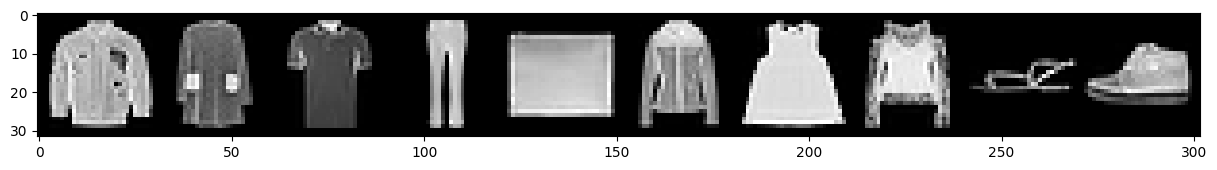

In [29]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

# test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
#                                               train=False,
#                                               transform=transforms.Compose([transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
sample = next(iter(data_loader))

imgs, lbls = sample

# create a grid
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

# Functions

Helper functions to define the model, make the confusion matrix, and train the model.

In [6]:
# define some helper functions
def get_item(preds, labels):
    """function that returns the accuracy of our architecture"""
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad() # turn off gradients during inference for memory effieciency
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    model = network
    for batch in dataloader:
        images, labels = batch
        preds = model(images) # get preds
        all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis

    return all_preds

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self, n_classes):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.batchN1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.batchN2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=n_classes)

    def forward(self, t): # implements the forward method (flow of tensors)

        # hidden conv layer
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        t = self.batchN1(t)

        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)

        # flatten
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.batchN2(t)
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)

        return t


def train_model(train_dataset, n_classes, cross_entropy_loss_fn="native_pytorch", epochs=5):
  assert cross_entropy_loss_fn in ("native_pytorch", "multiple_choice_cel")
  if cross_entropy_loss_fn == "native_pytorch":
    cross_entropy_loss_fn = F.cross_entropy
  elif cross_entropy_loss_fn == "multiple_choice_cel":
    cross_entropy_loss_fn = multiple_choice_cross_entropy
  else:
    raise

  train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

  cnn_model = Network(n_classes).cuda() # init model
  optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())

  for epoch in range(epochs):
      start_time = time.time()
      total_correct = 0
      total_loss = 0
      for batch in train_loader:
          imgs, lbls = batch
          imgs = imgs.cuda()
          lbls = lbls.cuda()
          preds = cnn_model(imgs) # get preds
          loss = cross_entropy_loss_fn(preds, lbls) # compute loss
          optimizer.zero_grad() # zero grads
          loss.backward() # calculates gradients
          optimizer.step() # update the weights

          total_loss += total_loss + loss.item()

          # TODO: Implement accuracy the same way as we do in the loss.
          # the label is A OR B, so if the model predicts either A OR B
          # then we consider that example correctly labeled.
      end_time = time.time() - start_time
      print("Epoch no.", epoch+1, "| train loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")

  return cnn_model

class CustomImageDataset(Dataset):
    """
    Create a custom wrapper around the dataset because we want our labels
    to be a vector instead of a single integer
    """
    # TODO: replace this with at target_transform in the normal torchvision
    # fashion MNist dataset so we don't have to do our own custom one.
    # https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html
    #
    def __init__(self, train_set, labels):
        self.inner_train_set = train_set
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inner_train_set[idx][0], self.labels[idx]

# Model 1: Full Labels, Normal Loss

In [7]:
m1_classes = ['background', 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
def m1_target_transform(target):
  """
  Transform the fashion mnist labels into our labes for model 1
  """
  target += 1
  if target > 6:
    target = 0
  return target

train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize(mean=0.2859, std=0.3530)
                                                                          ]),
                                              target_transform=m1_target_transform)


test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize(mean=0.2859, std=0.3530)
                                                                           ]),
                                              target_transform=m1_target_transform)

In [8]:
mod = train_model(train_set, len(m1_classes), epochs=10)

Epoch no. 1 | train loss:  7.046227935579982e+180 | epoch_duration:  27.78 sec
Epoch no. 2 | train loss:  1.2666782588249877e+180 | epoch_duration:  13.51 sec
Epoch no. 3 | train loss:  1.254079844241157e+180 | epoch_duration:  13.26 sec
Epoch no. 4 | train loss:  1.3682713242888072e+180 | epoch_duration:  13.34 sec
Epoch no. 5 | train loss:  9.750092275556293e+179 | epoch_duration:  13.23 sec
Epoch no. 6 | train loss:  1.162466782686749e+180 | epoch_duration:  13.68 sec
Epoch no. 7 | train loss:  1.0053406699072966e+180 | epoch_duration:  14.51 sec
Epoch no. 8 | train loss:  1.112896732284299e+180 | epoch_duration:  14.08 sec
Epoch no. 9 | train loss:  9.488937661686004e+179 | epoch_duration:  13.25 sec
Epoch no. 10 | train loss:  1.0496874457063205e+180 | epoch_duration:  12.98 sec


In [9]:
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=test_set, num_workers=1)
all_preds= get_all_preds(network=mod.cpu(), dataloader=pred_data_loader)

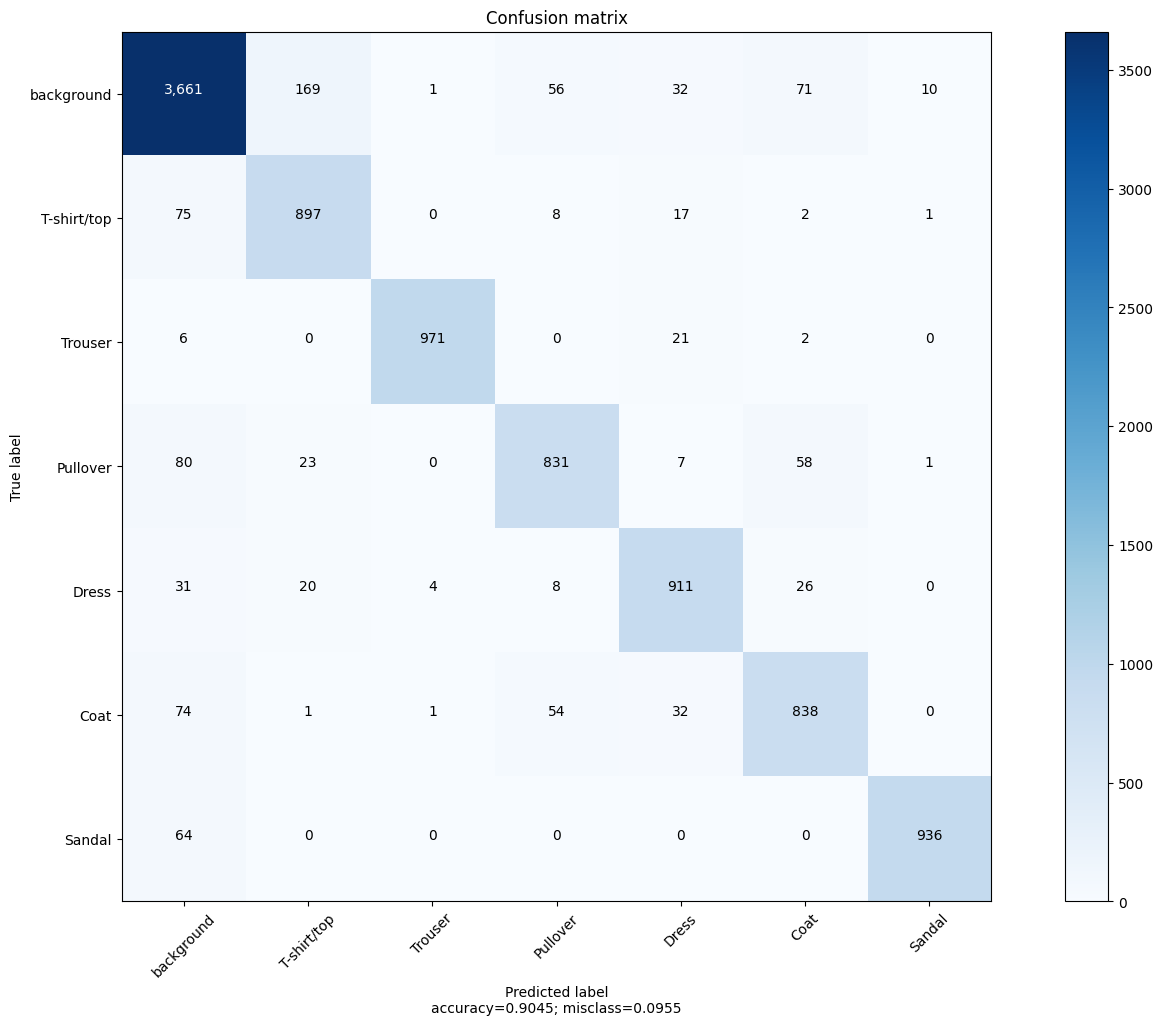

In [10]:
y_true = torch.clone(test_set.targets)
y_true = np.array(list(map(test_set.target_transform, y_true)))


plot_confusion_matrix(cm=confusion_matrix(y_true=y_true,
                      y_pred=all_preds.argmax(1)),
                      target_names=m1_classes, normalize=False)

# Model 2: Multiple Choice Labels, Normal Loss

## Create Dataset for Models 2 and 3

### Map the full schema to our two sub schemas
This simulates merging two different but overlapping labeling schemas.  

In [11]:
def make_c1_targets(targets):
  """
  Take as inputs the targets from normal fashion mnist and create targets
  labeled the way customer 1 labels them
  """
  targets_c1 = targets.clone()
  targets_c1 += 1
  targets_c1[targets_c1 > 4] = 0
  targets_c1 = torch.nn.functional.one_hot(targets_c1, num_classes=7)
  targets_c1[:, 5] += targets_c1[:, 0]
  targets_c1[:, 6] += targets_c1[:, 0]
  return targets_c1.type(torch.FloatTensor)

def make_c2_targets(targets):
  """
  Take as inputs the targets from normal fashion mnist and create targets
  labeled the way customer 1 labels them
  """
  targets_c2 = targets.clone()
  targets_c2 += 1
  targets_c2[(targets_c2 < 3) | (6 < targets_c2)] = 0
  targets_c2 = torch.nn.functional.one_hot(targets_c2, num_classes=7)
  targets_c2[:, 1] += targets_c2[:, 0]
  targets_c2[:, 2] += targets_c2[:, 0]
  return targets_c2.type(torch.FloatTensor)

def make_test_targets(targets):
  targets_test = targets.clone()
  targets_test += 1
  targets_test[targets_test > 6] = 0
  targets_test = torch.nn.functional.one_hot(targets_test, num_classes=7)
  return targets_test.type(torch.FloatTensor)

### What do these labels mean?

In [12]:
make_c1_targets(torch.tensor([0,1,2,3,4,5,6,7,8,9]))

tensor([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1.]])

In [13]:
"""
The first dataset has only labeled the classes 'T-shirt/top', 'Trouser',
'Pullover' and 'Dress' and originally considered everything else to be
'Background'. Now that we've added 2 more classes the Background class
becomes a bit ambiguous but we can still get information out of the labels.


tensor([[0, 1, 0, 0, 0, 0, 0], # 'T-shirt/top'
        [0, 0, 1, 0, 0, 0, 0], # 'Trouser'
        [0, 0, 0, 1, 0, 0, 0], # 'Pullover'
        [0, 0, 0, 0, 1, 0, 0], # 'Dress'
        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'
        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'
        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'
        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'
        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'
        [1, 0, 0, 0, 0, 1, 1]] # 'Background' OR 'Coat' OR 'Sandal'
        )
  """

"\nThe first dataset has only labeled the classes 'T-shirt/top', 'Trouser', \n'Pullover' and 'Dress' and originally considered everything else to be\n'Background'. Now that we've added 2 more classes the Background class\nbecomes a bit ambiguous but we can still get information out of the labels. \n\n\ntensor([[0, 1, 0, 0, 0, 0, 0], # 'T-shirt/top'\n        [0, 0, 1, 0, 0, 0, 0], # 'Trouser'\n        [0, 0, 0, 1, 0, 0, 0], # 'Pullover'\n        [0, 0, 0, 0, 1, 0, 0], # 'Dress'\n        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'\n        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'\n        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'\n        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'\n        [1, 0, 0, 0, 0, 1, 1], # 'Background' OR 'Coat' OR 'Sandal'\n        [1, 0, 0, 0, 0, 1, 1]] # 'Background' OR 'Coat' OR 'Sandal'\n        )\n  "

In [14]:
make_c2_targets(torch.tensor([0,1,2,3,4,5,6,7,8,9]))

tensor([[1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.]])

In [15]:
"""
The second dataset has only labeled the classes 'Pullover', 'Dress', 'Coat',
'Sandal', and 'Background'. Again we've converted the background class to
multiple possibilities including the classes that weren't included in this
dataset.

tensor([[1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'
        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'
        [0, 0, 0, 1, 0, 0, 0], # 'Pullover'
        [0, 0, 0, 0, 1, 0, 0], # 'Dress'
        [0, 0, 0, 0, 0, 1, 0], # 'Coat'
        [0, 0, 0, 0, 0, 0, 1], # 'Sandal'
        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'
        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'
        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'
        [1, 1, 1, 0, 0, 0, 0]] # 'Background' OR 'T-shirt/top' OR 'Trouser'
        )
"""

"\nThe second dataset has only labeled the classes 'Pullover', 'Dress', 'Coat',\n'Sandal', and 'Background'. Again we've converted the background class to \nmultiple possibilities including the classes that weren't included in this\ndataset. \n\ntensor([[1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'\n        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'\n        [0, 0, 0, 1, 0, 0, 0], # 'Pullover'\n        [0, 0, 0, 0, 1, 0, 0], # 'Dress'\n        [0, 0, 0, 0, 0, 1, 0], # 'Coat'\n        [0, 0, 0, 0, 0, 0, 1], # 'Sandal'\n        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'\n        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'\n        [1, 1, 1, 0, 0, 0, 0], # 'Background' OR 'T-shirt/top' OR 'Trouser'\n        [1, 1, 1, 0, 0, 0, 0]] # 'Background' OR 'T-shirt/top' OR 'Trouser'\n        )\n"

In [16]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize(mean=0.2859, std=0.3530)
                                                                          ]))


test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize(mean=0.2859, std=0.3530)
                                                                           ]))

new_targets = torch.zeros((len(train_set.targets), 7)).type(torch.FloatTensor)

# This will be the index of customer 1's subset.
index_sub = np.random.choice([True, False], len(train_set))
new_targets[index_sub] = make_c1_targets(train_set.targets[index_sub])
new_targets[~index_sub] = make_c2_targets(train_set.targets[~index_sub])



# new_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_set.data).type(torch.FloatTensor), new_targets)
m23_train_dataset = CustomImageDataset(train_set, new_targets)

new_test_targets = make_test_targets(test_set.targets)
m23_test_dataset = CustomImageDataset(test_set, new_test_targets)

In [17]:
mod = train_model(m23_train_dataset, 7, epochs=10)

Epoch no. 1 | train loss:  1.775212556078322e+181 | epoch_duration:  26.24 sec
Epoch no. 2 | train loss:  1.274100230616602e+181 | epoch_duration:  20.92 sec
Epoch no. 3 | train loss:  1.2350529408165371e+181 | epoch_duration:  15.94 sec
Epoch no. 4 | train loss:  1.216866205272653e+181 | epoch_duration:  19.72 sec
Epoch no. 5 | train loss:  1.2789190540595236e+181 | epoch_duration:  14.53 sec
Epoch no. 6 | train loss:  1.1866507428989454e+181 | epoch_duration:  14.22 sec
Epoch no. 7 | train loss:  1.1735918530466605e+181 | epoch_duration:  13.38 sec
Epoch no. 8 | train loss:  1.247471082664114e+181 | epoch_duration:  13.46 sec
Epoch no. 9 | train loss:  1.214687985877961e+181 | epoch_duration:  13.66 sec
Epoch no. 10 | train loss:  1.2336553658105688e+181 | epoch_duration:  14.77 sec


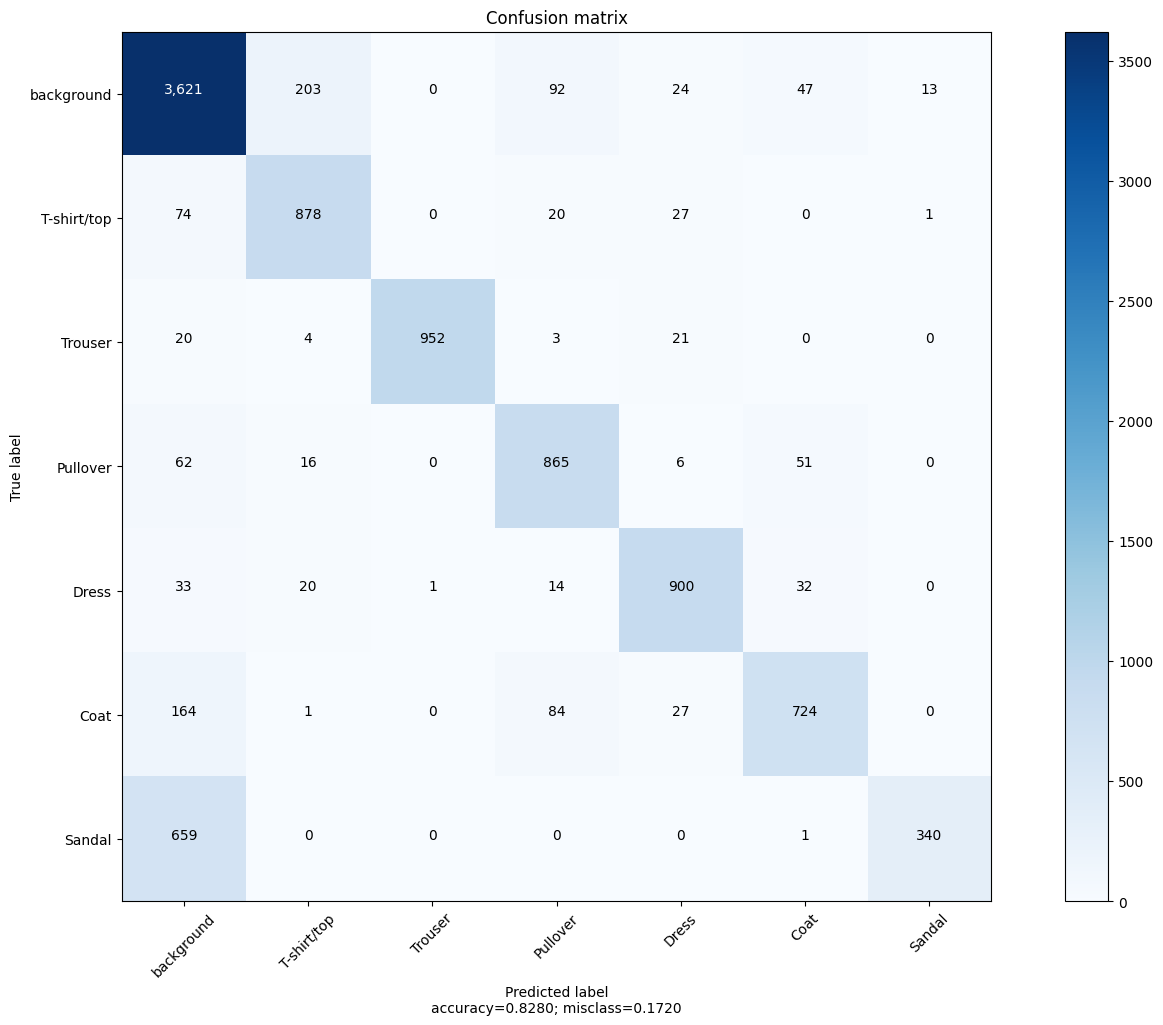

In [18]:
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=m23_test_dataset, num_workers=1)
all_preds= get_all_preds(network=mod.cpu(), dataloader=pred_data_loader)
plot_confusion_matrix(cm=confusion_matrix(y_true=m23_test_dataset.labels.argmax(1),
                      y_pred=all_preds.argmax(1)),
                      target_names=m1_classes, normalize=False)

# Model 3: Multiple Choice Labels, SchemaFuse Loss

In [20]:
mod = train_model(m23_train_dataset, 7, epochs=10, cross_entropy_loss_fn="multiple_choice_cel")

Epoch no. 1 | train loss:  4.664595911460827e+180 | epoch_duration:  14.16 sec
Epoch no. 2 | train loss:  1.015193886258944e+180 | epoch_duration:  18.01 sec
Epoch no. 3 | train loss:  9.328823286888275e+179 | epoch_duration:  13.59 sec
Epoch no. 4 | train loss:  6.621455761579565e+179 | epoch_duration:  13.73 sec
Epoch no. 5 | train loss:  6.456544521626422e+179 | epoch_duration:  14.48 sec
Epoch no. 6 | train loss:  8.277885827654565e+179 | epoch_duration:  13.56 sec
Epoch no. 7 | train loss:  6.867179263543352e+179 | epoch_duration:  13.74 sec
Epoch no. 8 | train loss:  8.67204148850392e+179 | epoch_duration:  13.67 sec
Epoch no. 9 | train loss:  7.882742354542392e+179 | epoch_duration:  13.73 sec
Epoch no. 10 | train loss:  6.611350491435477e+179 | epoch_duration:  14.03 sec


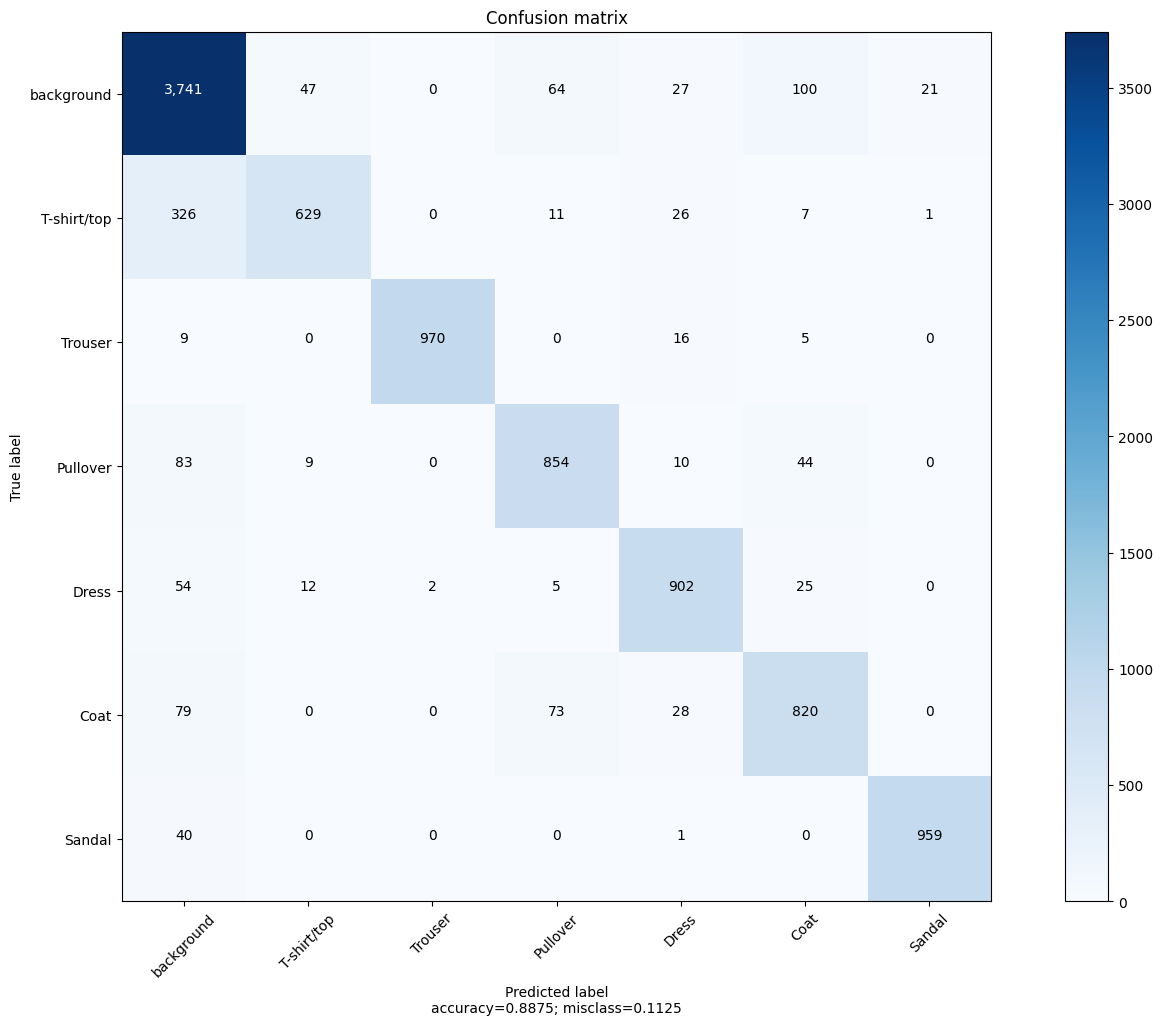

In [21]:
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=m23_test_dataset, num_workers=1)
all_preds= get_all_preds(network=mod.cpu(), dataloader=pred_data_loader)
plot_confusion_matrix(cm=confusion_matrix(y_true=m23_test_dataset.labels.argmax(1),
                      y_pred=all_preds.argmax(1)),
                      target_names=m1_classes, normalize=False)